In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
import string
from scipy.stats import mannwhitneyu

from seqme.metrics.physicochem import calculate_physchem
from seqme.utils import random_subset, read_fasta_file
from config_paths import PATHS_FOR_CONTROL, PATHS_FOR_MODELS

In [2]:
datasets = {name: read_fasta_file(path) for name, path in (PATHS_FOR_CONTROL | PATHS_FOR_MODELS).items()}

for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

positives: 14941 sequences
positives_hq: 3322 sequences
negatives: 14814 sequences
negatives_hq: 925 sequences
random_uniform: 50000 sequences
random_standard: 50000 sequences
UniProt: 50000 sequences
AMP-Diffusion: 47671 sequences
AMP-GAN: 50000 sequences
CPL-Diff: 46305 sequences
HydrAMP: 50000 sequences
OmegAMP: 50000 sequences
AMP-LM: 25608 sequences
AMP-Muller: 1052 sequences


In [3]:
len(datasets.keys())

14

In [5]:
physicochem_results_df = calculate_physchem(peptides=datasets.values(), datasets=datasets.keys())

In [7]:
physicochem_results_df['fitness'].min()

np.float64(1.2796794258205019e-17)

In [54]:
hydramp_data = physicochem_results_df.loc[
    physicochem_results_df['dataset'] == 'HydrAMP'
]

hydramp_data['fitness'].median()

np.float64(0.07351650884315691)

In [55]:
negatives_data = physicochem_results_df.loc[
    physicochem_results_df['dataset'] == 'negatives'
]

negatives_data['fitness'].median()

np.float64(0.0636838484390986)

In [56]:
mannwhitneyu(hydramp_data['fitness'], negatives_data['fitness'], alternative='greater')

MannwhitneyuResult(statistic=np.float64(401878520.0), pvalue=np.float64(2.801528901366103e-56))

In [58]:
labels_dict = {
    'charge': 'Charge',
    'pi': 'Isoelectric Point',
    'aromacity': 'Aromaticity',
    'hydrophobicity': 'Hydrophobicity',
    'hm': 'Hydrophobic Moment',
    'fitness': 'Fitness Score'
}

def choose_symbol(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

In [60]:
physicochem_results_df['dataset'].unique()

array(['positives', 'positives_hq', 'negatives', 'negatives_hq',
       'random_uniform', 'random_standard', 'UniProt', 'AMP-Diffusion',
       'AMP-GAN', 'CPL-Diff', 'HydrAMP', 'OmegAMP', 'AMP-LM',
       'AMP-Muller'], dtype=object)

In [62]:
sorted(physicochem_results_df['dataset'].unique())

['AMP-Diffusion',
 'AMP-GAN',
 'AMP-LM',
 'AMP-Muller',
 'CPL-Diff',
 'HydrAMP',
 'OmegAMP',
 'UniProt',
 'negatives',
 'negatives_hq',
 'positives',
 'positives_hq',
 'random_standard',
 'random_uniform']

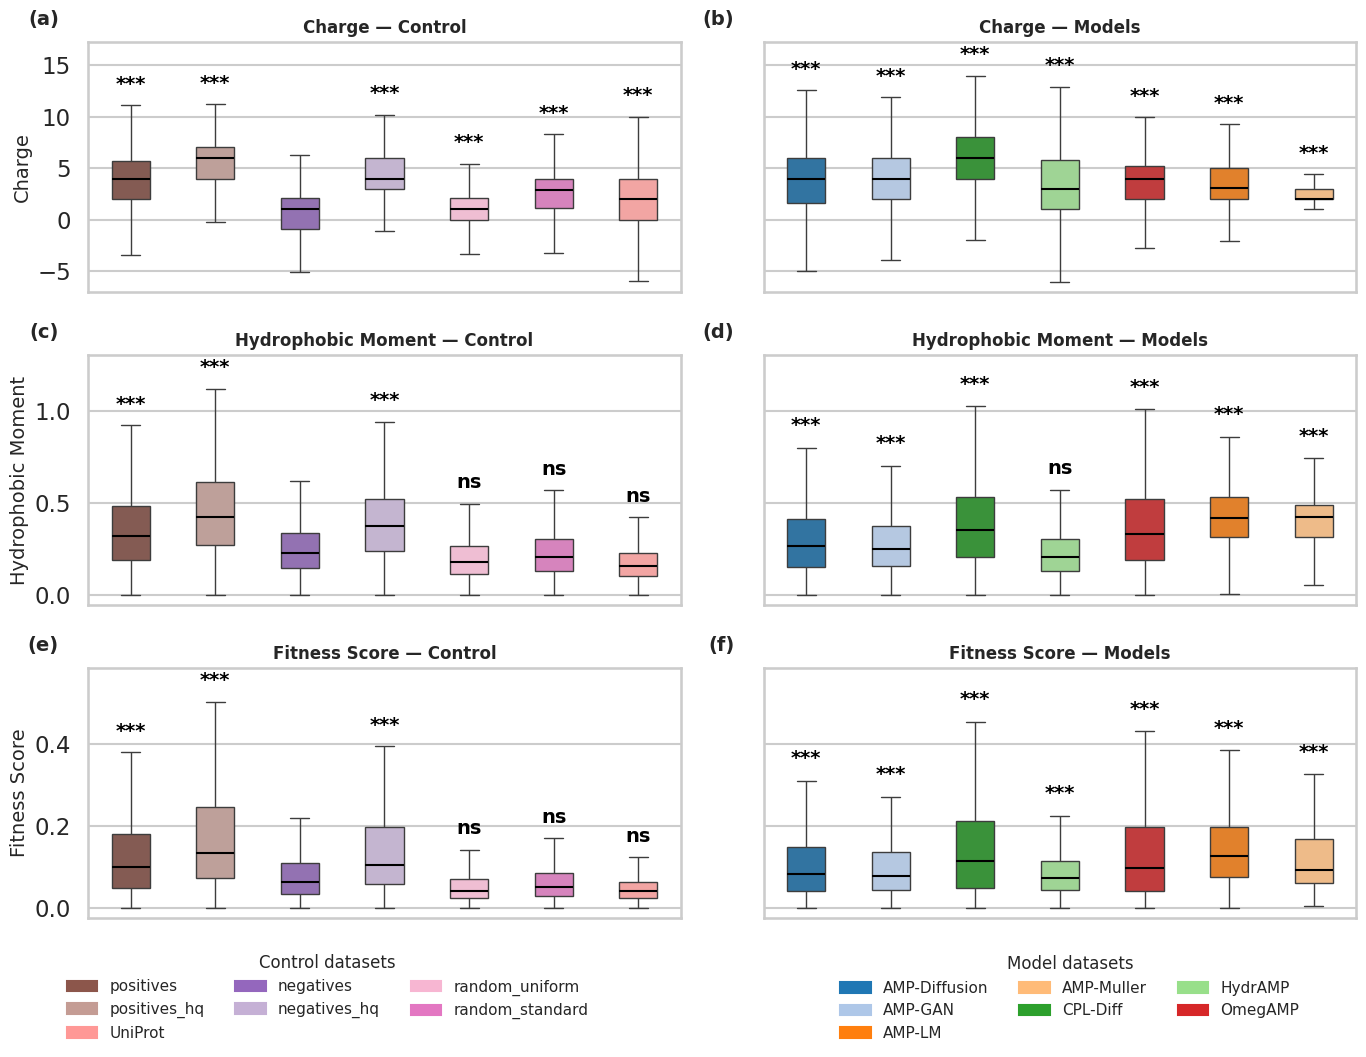

In [71]:
properties = ['charge', 'hm', 'fitness']
group1 = ['positives', 'positives_hq', 'negatives', 'negatives_hq',
          'random_uniform', 'random_standard', 'UniProt']

group2 = ['AMP-Muller', 'AMP-LM', 'AMP-GAN', 'HydrAMP', 'AMP-Diffusion', 'CPL-Diff', 'OmegaAMP']

all_datasets = sorted(physicochem_results_df['dataset'].unique())
palette = sns.color_palette("tab20", n_colors=len(all_datasets))
color_dict = dict(zip(all_datasets, palette))

sns.set_theme(style="whitegrid", context="talk")
fig, axes = plt.subplots(len(properties), 2,
                         figsize=(14, 3.5 * len(properties)),
                         sharey='row')

baseline = 'negatives'
baseline_data = physicochem_results_df.loc[
    physicochem_results_df['dataset'] == baseline
]

for i, prop in enumerate(properties):
    left_df = physicochem_results_df[
        physicochem_results_df['dataset'].isin(group1)
    ].copy()
    right_df = physicochem_results_df[
        ~physicochem_results_df['dataset'].isin(group1)
    ].copy()

    sns.boxplot(
        data=left_df, x='dataset', y=prop,
        hue='dataset', palette=color_dict, dodge=False,
        showfliers=False, width=0.45,
        medianprops={'color': 'black', 'linewidth': 1.5},
        ax=axes[i, 0], legend=False
    )
    axes[i, 0].set_title(f"{labels_dict[prop]} — Control", fontsize=12, weight='bold')
    axes[i, 0].set_xlabel("")
    axes[i, 0].set_ylabel(labels_dict[prop], fontsize=14)
    axes[i, 0].set_xticklabels([])

    sns.boxplot(
        data=right_df, x='dataset', y=prop,
        hue='dataset', palette=color_dict, dodge=False,
        showfliers=False, width=0.45,
        medianprops={'color': 'black', 'linewidth': 1.5},
        ax=axes[i, 1], legend=False
    )
    axes[i, 1].set_title(f"{labels_dict[prop]} — Models", fontsize=12, weight='bold')
    axes[i, 1].set_xlabel("")
    axes[i, 1].set_ylabel("")
    axes[i, 1].set_xticklabels([])

    for ax, df_sub in zip([axes[i, 0], axes[i, 1]], [left_df, right_df]):
        categories = df_sub['dataset'].unique().tolist()

        ylim_bottom, ylim_top = ax.get_ylim()

        for j, dataset in enumerate(categories):
            if dataset == baseline:
                continue

            data1 = df_sub.loc[df_sub['dataset'] == dataset, prop].dropna()
            data2 = baseline_data[prop].dropna()
            if len(data1) == 0 or len(data2) == 0:
                continue

            stat, p = mannwhitneyu(data1, data2, alternative='greater')
            symbol = choose_symbol(p)

            q1, q3 = np.percentile(data1, [25, 75])
            iqr = q3 - q1
            whisker_top = data1[data1 <= q3 + 1.5 * iqr].max()
            y_pos = whisker_top + 0.05 * (ylim_top - ylim_bottom)

            if y_pos > ylim_top:
                ax.set_ylim(ylim_bottom, y_pos + 0.1 * (ylim_top - ylim_bottom))

            ax.text(j, y_pos, symbol,
                    ha='center', va='bottom',
                    fontsize=14, fontweight='bold', color='black')

labels = list(string.ascii_lowercase)
for idx, ax in enumerate(axes.flat):
    label = f"({labels[idx]})"
    ax.text(-0.05, 1.05, label, transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='bottom', ha='right')

group1_legend = ['positives', 'positives_hq', 'UniProt', 'negatives', 'negatives_hq',
                 'random_uniform', 'random_standard']
legend_handles_control = [Patch(facecolor=color_dict[d], edgecolor=color_dict[d], label=d) for d in group1_legend]
legend_handles_models = [Patch(facecolor=color_dict[d], edgecolor=color_dict[d], label=d)
                         for d in all_datasets if d not in group1]

fig.legend(handles=legend_handles_control, title="Control datasets",
           loc='lower left', bbox_to_anchor=(0.05, -0.02),
           ncol=3, frameon=False,
           fontsize=11, title_fontsize=12)
fig.legend(handles=legend_handles_models, title="Model datasets",
           loc='lower right', bbox_to_anchor=(0.95, -0.02),
           ncol=3, frameon=False,
           fontsize=11, title_fontsize=12)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()
